## **4.1 Load Artifacts (Scaler, Models, Thresholds, Features)**

In [1]:
# === 1. Import Libraries ===
import os
import random
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import KernelPCA

# === 2. Define Project Paths ===
PHASE_NUMBER = 4

RESULT_DIR = f"result/phase_{PHASE_NUMBER}"
PLOT_DIR = os.path.join(RESULT_DIR, "plot")
DATA_DIR = os.path.join(RESULT_DIR, "data")

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Phase {PHASE_NUMBER} directories created/verified:")
print(f"  Plots: {PLOT_DIR}")
print(f"  Data:  {DATA_DIR}")

# === 3. Set Random Seed for Reproducibility ===
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print(f"Random seed set to {SEED}")

# === 4. Matplotlib Plotting Settings (for IEEE) ===
def setup_ieee_plots():
    """Apply consistent, professional plot settings for IEEE publication."""
    plt.rcParams.update({
        'figure.figsize': (8, 5),
        'figure.dpi': 300,
        'font.family': 'serif',
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2,
        'lines.markersize': 5,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'axes.grid': True,
    })
    print("IEEE plot settings applied.")

setup_ieee_plots()

# === 5. Load Phase 2 Features ===
features_df = pd.read_csv('result/phase_2/data/features.csv')
print(f"\nLoaded features: {features_df.shape}")
print(f"Cycle range: {features_df['cycle_idx'].min()} to {features_df['cycle_idx'].max()}")
print(features_df.head(3))

# === 6. Load Phase 3 Artifacts ===
with open('result/phase_3/data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print(f"\nScaler loaded: MinMaxScaler, range={scaler.feature_range}")

with open('result/phase_3/data/scaling_params.json', 'r') as f:
    scaling_params = json.load(f)
print(f"Scaling params: {scaling_params['n_features']} features")

with open('result/phase_3/data/quantum_kernel_params.json', 'r') as f:
    quantum_params = json.load(f)
print(f"\nQuantum kernel: {quantum_params['type']}, depth={quantum_params['depth']}, qubits={quantum_params['n_qubits']}")

with open('result/phase_3/data/baseline_kernel_params.json', 'r') as f:
    baseline_params = json.load(f)
print(f"\nBaseline kernels:")
for kernel_name, params in baseline_params.items():
    print(f"  {kernel_name}: {params}")

K_quantum_full = np.load('result/phase_3/data/K_quantum_full.npy')
K_rbf_full = np.load('result/phase_3/data/K_rbf_full.npy')
K_laplacian_full = np.load('result/phase_3/data/K_laplacian_full.npy')
K_poly2_full = np.load('result/phase_3/data/K_poly2_full.npy')
K_poly3_full = np.load('result/phase_3/data/K_poly3_full.npy')
print(f"\nKernel matrices loaded: {K_quantum_full.shape}")

with open('result/phase_3/data/ocsvm_quantum.pkl', 'rb') as f:
    ocsvm_quantum = pickle.load(f)
with open('result/phase_3/data/ocsvm_rbf.pkl', 'rb') as f:
    ocsvm_rbf = pickle.load(f)
with open('result/phase_3/data/ocsvm_laplacian.pkl', 'rb') as f:
    ocsvm_laplacian = pickle.load(f)
with open('result/phase_3/data/ocsvm_poly2.pkl', 'rb') as f:
    ocsvm_poly2 = pickle.load(f)
with open('result/phase_3/data/ocsvm_poly3.pkl', 'rb') as f:
    ocsvm_poly3 = pickle.load(f)
print("OCSVM models loaded (5 total)")

with open('result/phase_3/data/thresholds.json', 'r') as f:
    thresholds = json.load(f)
print(f"\nThresholds (anomaly flagged when score < threshold):")
for model, thresh in thresholds.items():
    print(f"  {model}: {thresh:.6f}")

print("\nPhase 4.1 Complete")
print(f"Ready to score {len(features_df)} cycles")

Phase 4 directories created/verified:
  Plots: result/phase_4\plot
  Data:  result/phase_4\data
Random seed set to 42
IEEE plot settings applied.

Loaded features: (1241, 9)
Cycle range: 1 to 1241
   cycle_idx  capacity_Ah  energy_Wh  duration_s  v_min    v_max    v_mean  \
0          1     3.270184  11.696697      3680.0    3.0  4.08156  3.576643   
1          2     3.266630  11.682788      3676.0    3.0  4.08171  3.576276   
2          3     3.265743  11.679512      3675.0    3.0  4.08232  3.576245   

      i_rms  dVdt_abs_mean  
0  3.199528       0.000362  
1  3.199529       0.000363  
2  3.199531       0.000360  

Scaler loaded: MinMaxScaler, range=(0, 3.141592653589793)
Scaling params: 8 features

Quantum kernel: ZZ_Pauli_entangling, depth=2, qubits=8

Baseline kernels:
  rbf: {'type': 'radial_basis_function', 'gamma': 0.041459516957689756, 'gamma_method': 'median_heuristic', 'median_distance': 3.472744908422876}
  laplacian: {'type': 'laplacian', 'gamma': 0.041459516957689756, '

## **4.2 Score All Cycles (Quantum & RBF & Others)**

In [2]:
scores_quantum = ocsvm_quantum.decision_function(K_quantum_full)
print(f"Quantum scores: shape={scores_quantum.shape}, range=[{scores_quantum.min():.6f}, {scores_quantum.max():.6f}]")

scores_rbf = ocsvm_rbf.decision_function(K_rbf_full)
print(f"RBF scores: shape={scores_rbf.shape}, range=[{scores_rbf.min():.6f}, {scores_rbf.max():.6f}]")

scores_laplacian = ocsvm_laplacian.decision_function(K_laplacian_full)
print(f"Laplacian scores: shape={scores_laplacian.shape}, range=[{scores_laplacian.min():.6f}, {scores_laplacian.max():.6f}]")

scores_poly2 = ocsvm_poly2.decision_function(K_poly2_full)
print(f"Poly2 scores: shape={scores_poly2.shape}, range=[{scores_poly2.min():.6f}, {scores_poly2.max():.6f}]")

scores_poly3 = ocsvm_poly3.decision_function(K_poly3_full)
print(f"Poly3 scores: shape={scores_poly3.shape}, range=[{scores_poly3.min():.6f}, {scores_poly3.max():.6f}]")

features_df['score_quantum'] = scores_quantum
features_df['score_rbf'] = scores_rbf
features_df['score_laplacian'] = scores_laplacian
features_df['score_poly2'] = scores_poly2
features_df['score_poly3'] = scores_poly3

features_df['anomaly_quantum'] = scores_quantum < thresholds['quantum']
features_df['anomaly_rbf'] = scores_rbf < thresholds['rbf']
features_df['anomaly_laplacian'] = scores_laplacian < thresholds['laplacian']
features_df['anomaly_poly2'] = scores_poly2 < thresholds['poly2']
features_df['anomaly_poly3'] = scores_poly3 < thresholds['poly3']

print("\n=== Anomaly Detection Summary ===")
print(f"Total cycles: {len(features_df)}")
print(f"Training cycles (1-20): 20")
print(f"Test cycles (21-{len(features_df)}): {len(features_df) - 20}")
print("\nAnomalies detected (total):")
print(f"  Quantum: {features_df['anomaly_quantum'].sum()}")
print(f"  RBF: {features_df['anomaly_rbf'].sum()}")
print(f"  Laplacian: {features_df['anomaly_laplacian'].sum()}")
print(f"  Poly2: {features_df['anomaly_poly2'].sum()}")
print(f"  Poly3: {features_df['anomaly_poly3'].sum()}")

print("\nAnomalies in training range (cycles 1-20):")
print(f"  Quantum: {features_df.loc[features_df['cycle_idx'] <= 20, 'anomaly_quantum'].sum()}")
print(f"  RBF: {features_df.loc[features_df['cycle_idx'] <= 20, 'anomaly_rbf'].sum()}")

print("\nSample scores (first 5 and last 5 cycles):")
print(features_df[['cycle_idx', 'capacity_Ah', 'score_quantum', 'score_rbf', 'anomaly_quantum', 'anomaly_rbf']].head())
print("...")
print(features_df[['cycle_idx', 'capacity_Ah', 'score_quantum', 'score_rbf', 'anomaly_quantum', 'anomaly_rbf']].tail())

print("\nPhase 4.2 Complete")

Quantum scores: shape=(1241,), range=[-0.097436, 0.022225]
RBF scores: shape=(1241,), range=[-0.478602, 0.080326]
Laplacian scores: shape=(1241,), range=[-0.678530, 0.037609]
Poly2 scores: shape=(1241,), range=[-9.004235, 3542022.559067]
Poly3 scores: shape=(1241,), range=[-57426.678297, 8534751315.130705]

=== Anomaly Detection Summary ===
Total cycles: 1241
Training cycles (1-20): 20
Test cycles (21-1241): 1221

Anomalies detected (total):
  Quantum: 1192
  RBF: 1222
  Laplacian: 1222
  Poly2: 123
  Poly3: 1215

Anomalies in training range (cycles 1-20):
  Quantum: 1
  RBF: 1

Sample scores (first 5 and last 5 cycles):
   cycle_idx  capacity_Ah  score_quantum  score_rbf  anomaly_quantum  \
0          1     3.270184       0.000425  -0.000194            False   
1          2     3.266630      -0.000059   0.031081            False   
2          3     3.265743      -0.000033   0.025487            False   
3          4     3.266631       0.000078  -0.000320            False   
4          

## **4.3 Compute 80%-Capacity Cycle (C80) and First-Alarm Cycle per Model**

In [3]:
C_ref = features_df.loc[features_df['cycle_idx'] == 1, 'capacity_Ah'].values[0]
C80 = 0.8 * C_ref

print(f"=== Capacity Reference ===")
print(f"C_ref (cycle 1): {C_ref:.6f} Ah")
print(f"C80 (80% threshold): {C80:.6f} Ah")

c80_mask = features_df['capacity_Ah'] <= C80
if c80_mask.any():
    c80_cycle = features_df.loc[c80_mask, 'cycle_idx'].min()
    c80_capacity = features_df.loc[features_df['cycle_idx'] == c80_cycle, 'capacity_Ah'].values[0]
    print(f"\n80%-capacity cycle: {c80_cycle}")
    print(f"  Capacity at cycle {c80_cycle}: {c80_capacity:.6f} Ah ({c80_capacity/C_ref*100:.2f}% of C_ref)")
else:
    c80_cycle = None
    print("\nWARNING: Battery never reached 80% capacity threshold")

models = ['quantum', 'rbf', 'laplacian', 'poly2', 'poly3']
first_alarms = {}

print(f"\n=== First Alarm Detection ===")
print("(First anomaly detected after training range, cycles 21+)")

for model in models:
    anomaly_col = f'anomaly_{model}'
    
    post_training_anomalies = features_df[
        (features_df['cycle_idx'] > 20) & 
        (features_df[anomaly_col] == True)
    ]
    
    if len(post_training_anomalies) > 0:
        first_alarm_cycle = post_training_anomalies['cycle_idx'].min()
        first_alarm_capacity = features_df.loc[
            features_df['cycle_idx'] == first_alarm_cycle, 
            'capacity_Ah'
        ].values[0]
        first_alarm_score = features_df.loc[
            features_df['cycle_idx'] == first_alarm_cycle,
            f'score_{model}'
        ].values[0]
        
        first_alarms[model] = {
            'cycle': int(first_alarm_cycle),
            'capacity_Ah': float(first_alarm_capacity),
            'score': float(first_alarm_score),
            'threshold': thresholds[model]
        }
        
        print(f"\n{model.upper()}:")
        print(f"  First alarm cycle: {first_alarm_cycle}")
        print(f"  Capacity: {first_alarm_capacity:.6f} Ah ({first_alarm_capacity/C_ref*100:.2f}% of C_ref)")
        print(f"  Score: {first_alarm_score:.6f} (threshold: {thresholds[model]:.6f})")
    else:
        first_alarms[model] = {
            'cycle': None,
            'capacity_Ah': None,
            'score': None,
            'threshold': thresholds[model]
        }
        print(f"\n{model.upper()}: No post-training anomaly detected")

first_alarms['c_ref'] = float(C_ref)
first_alarms['c80'] = float(C80)
first_alarms['c80_cycle'] = int(c80_cycle) if c80_cycle is not None else None

with open(os.path.join(DATA_DIR, 'first_alarms.json'), 'w') as f:
    json.dump(first_alarms, f, indent=2)

print(f"\nPhase 4.3 Complete")
print(f"First alarms saved to {os.path.join(DATA_DIR, 'first_alarms.json')}")

=== Capacity Reference ===
C_ref (cycle 1): 3.270184 Ah
C80 (80% threshold): 2.616147 Ah

80%-capacity cycle: 965
  Capacity at cycle 965: 2.587524 Ah (79.12% of C_ref)

=== First Alarm Detection ===
(First anomaly detected after training range, cycles 21+)

QUANTUM:
  First alarm cycle: 21
  Capacity: 3.230185 Ah (98.78% of C_ref)
  Score: -0.068289 (threshold: -0.000361)

RBF:
  First alarm cycle: 21
  Capacity: 3.230185 Ah (98.78% of C_ref)
  Score: -0.030576 (threshold: -0.000320)

LAPLACIAN:
  First alarm cycle: 21
  Capacity: 3.230185 Ah (98.78% of C_ref)
  Score: -0.031491 (threshold: -0.000228)

POLY2:
  First alarm cycle: 24
  Capacity: 3.226626 Ah (98.67% of C_ref)
  Score: -2.369616 (threshold: 0.000000)

POLY3:
  First alarm cycle: 24
  Capacity: 3.226626 Ah (98.67% of C_ref)
  Score: -9.758439 (threshold: 0.000001)

Phase 4.3 Complete
First alarms saved to result/phase_4\data\first_alarms.json


## **4.4 Lead-Time & AUROC Computation**

In [4]:
print("=== Lead-Time Analysis ===")
print(f"80%-capacity cycle (C80): {c80_cycle}")
print(f"Training range: cycles 1-20\n")

lead_times = {}

for model in models:
    first_alarm_cycle = first_alarms[model]['cycle']
    
    if first_alarm_cycle is not None and c80_cycle is not None:
        lead_time = c80_cycle - first_alarm_cycle
        lead_times[model] = lead_time
        
        print(f"{model.upper()}:")
        print(f"  First alarm: cycle {first_alarm_cycle}")
        print(f"  Lead-time: {lead_time} cycles")
        print(f"  Interpretation: {'Early warning' if lead_time > 0 else 'Late detection'}")
    else:
        lead_times[model] = None
        print(f"{model.upper()}: No alarm → No lead-time")
    print()

print("=== AUROC Computation (Early vs Late Discrimination) ===")
print(f"Early cycles: 1 to {c80_cycle} (n={c80_cycle})")
print(f"Late cycles: {c80_cycle+1} to {len(features_df)} (n={len(features_df)-c80_cycle})\n")

y_true = (features_df['cycle_idx'] > c80_cycle).astype(int)

auroc_scores = {}

for model in models:
    score_col = f'score_{model}'
    
    y_score = -features_df[score_col].values
    
    auroc = roc_auc_score(y_true, y_score)
    auroc_scores[model] = float(auroc)
    
    print(f"{model.upper()}: AUROC = {auroc:.4f}")

metrics_data = []

model_objects = {
    'quantum': ocsvm_quantum,
    'rbf': ocsvm_rbf,
    'laplacian': ocsvm_laplacian,
    'poly2': ocsvm_poly2,
    'poly3': ocsvm_poly3
}

for model in models:
    metrics_data.append({
        'model': model,
        'first_alarm_cycle': first_alarms[model]['cycle'],
        'c80_cycle': c80_cycle,
        'lead_time': lead_times[model],
        'auroc': auroc_scores[model],
        'fpr_train': 0.05,
        'threshold': thresholds[model],
        'n_support_vectors': model_objects[model].n_support_[0]
    })

metrics_df = pd.DataFrame(metrics_data)

metrics_df['early_warning'] = metrics_df['lead_time'].apply(
    lambda x: 'Yes' if x is not None and x > 0 else 'No' if x is not None else 'N/A'
)

print("\n=== Metrics Summary Table ===")
print(metrics_df.to_string(index=False))

metrics_df.to_csv(os.path.join(DATA_DIR, 'metrics_summary.csv'), index=False)

print("\nPhase 4.4 Complete")
print(f"Metrics saved to {os.path.join(DATA_DIR, 'metrics_summary.csv')}")

=== Lead-Time Analysis ===
80%-capacity cycle (C80): 965
Training range: cycles 1-20

QUANTUM:
  First alarm: cycle 21
  Lead-time: 944 cycles
  Interpretation: Early warning

RBF:
  First alarm: cycle 21
  Lead-time: 944 cycles
  Interpretation: Early warning

LAPLACIAN:
  First alarm: cycle 21
  Lead-time: 944 cycles
  Interpretation: Early warning

POLY2:
  First alarm: cycle 24
  Lead-time: 941 cycles
  Interpretation: Early warning

POLY3:
  First alarm: cycle 24
  Lead-time: 941 cycles
  Interpretation: Early warning

=== AUROC Computation (Early vs Late Discrimination) ===
Early cycles: 1 to 965 (n=965)
Late cycles: 966 to 1241 (n=276)

QUANTUM: AUROC = 0.4954
RBF: AUROC = 0.5756
LAPLACIAN: AUROC = 0.9998
POLY2: AUROC = 0.0005
POLY3: AUROC = 0.9961

=== Metrics Summary Table ===
    model  first_alarm_cycle  c80_cycle  lead_time    auroc  fpr_train     threshold  n_support_vectors early_warning
  quantum                 21        965        944 0.495401       0.05 -3.605755e-04 

## **4.5 Plot Capacity vs. Cycle (capacity_vs_cycle.png)**

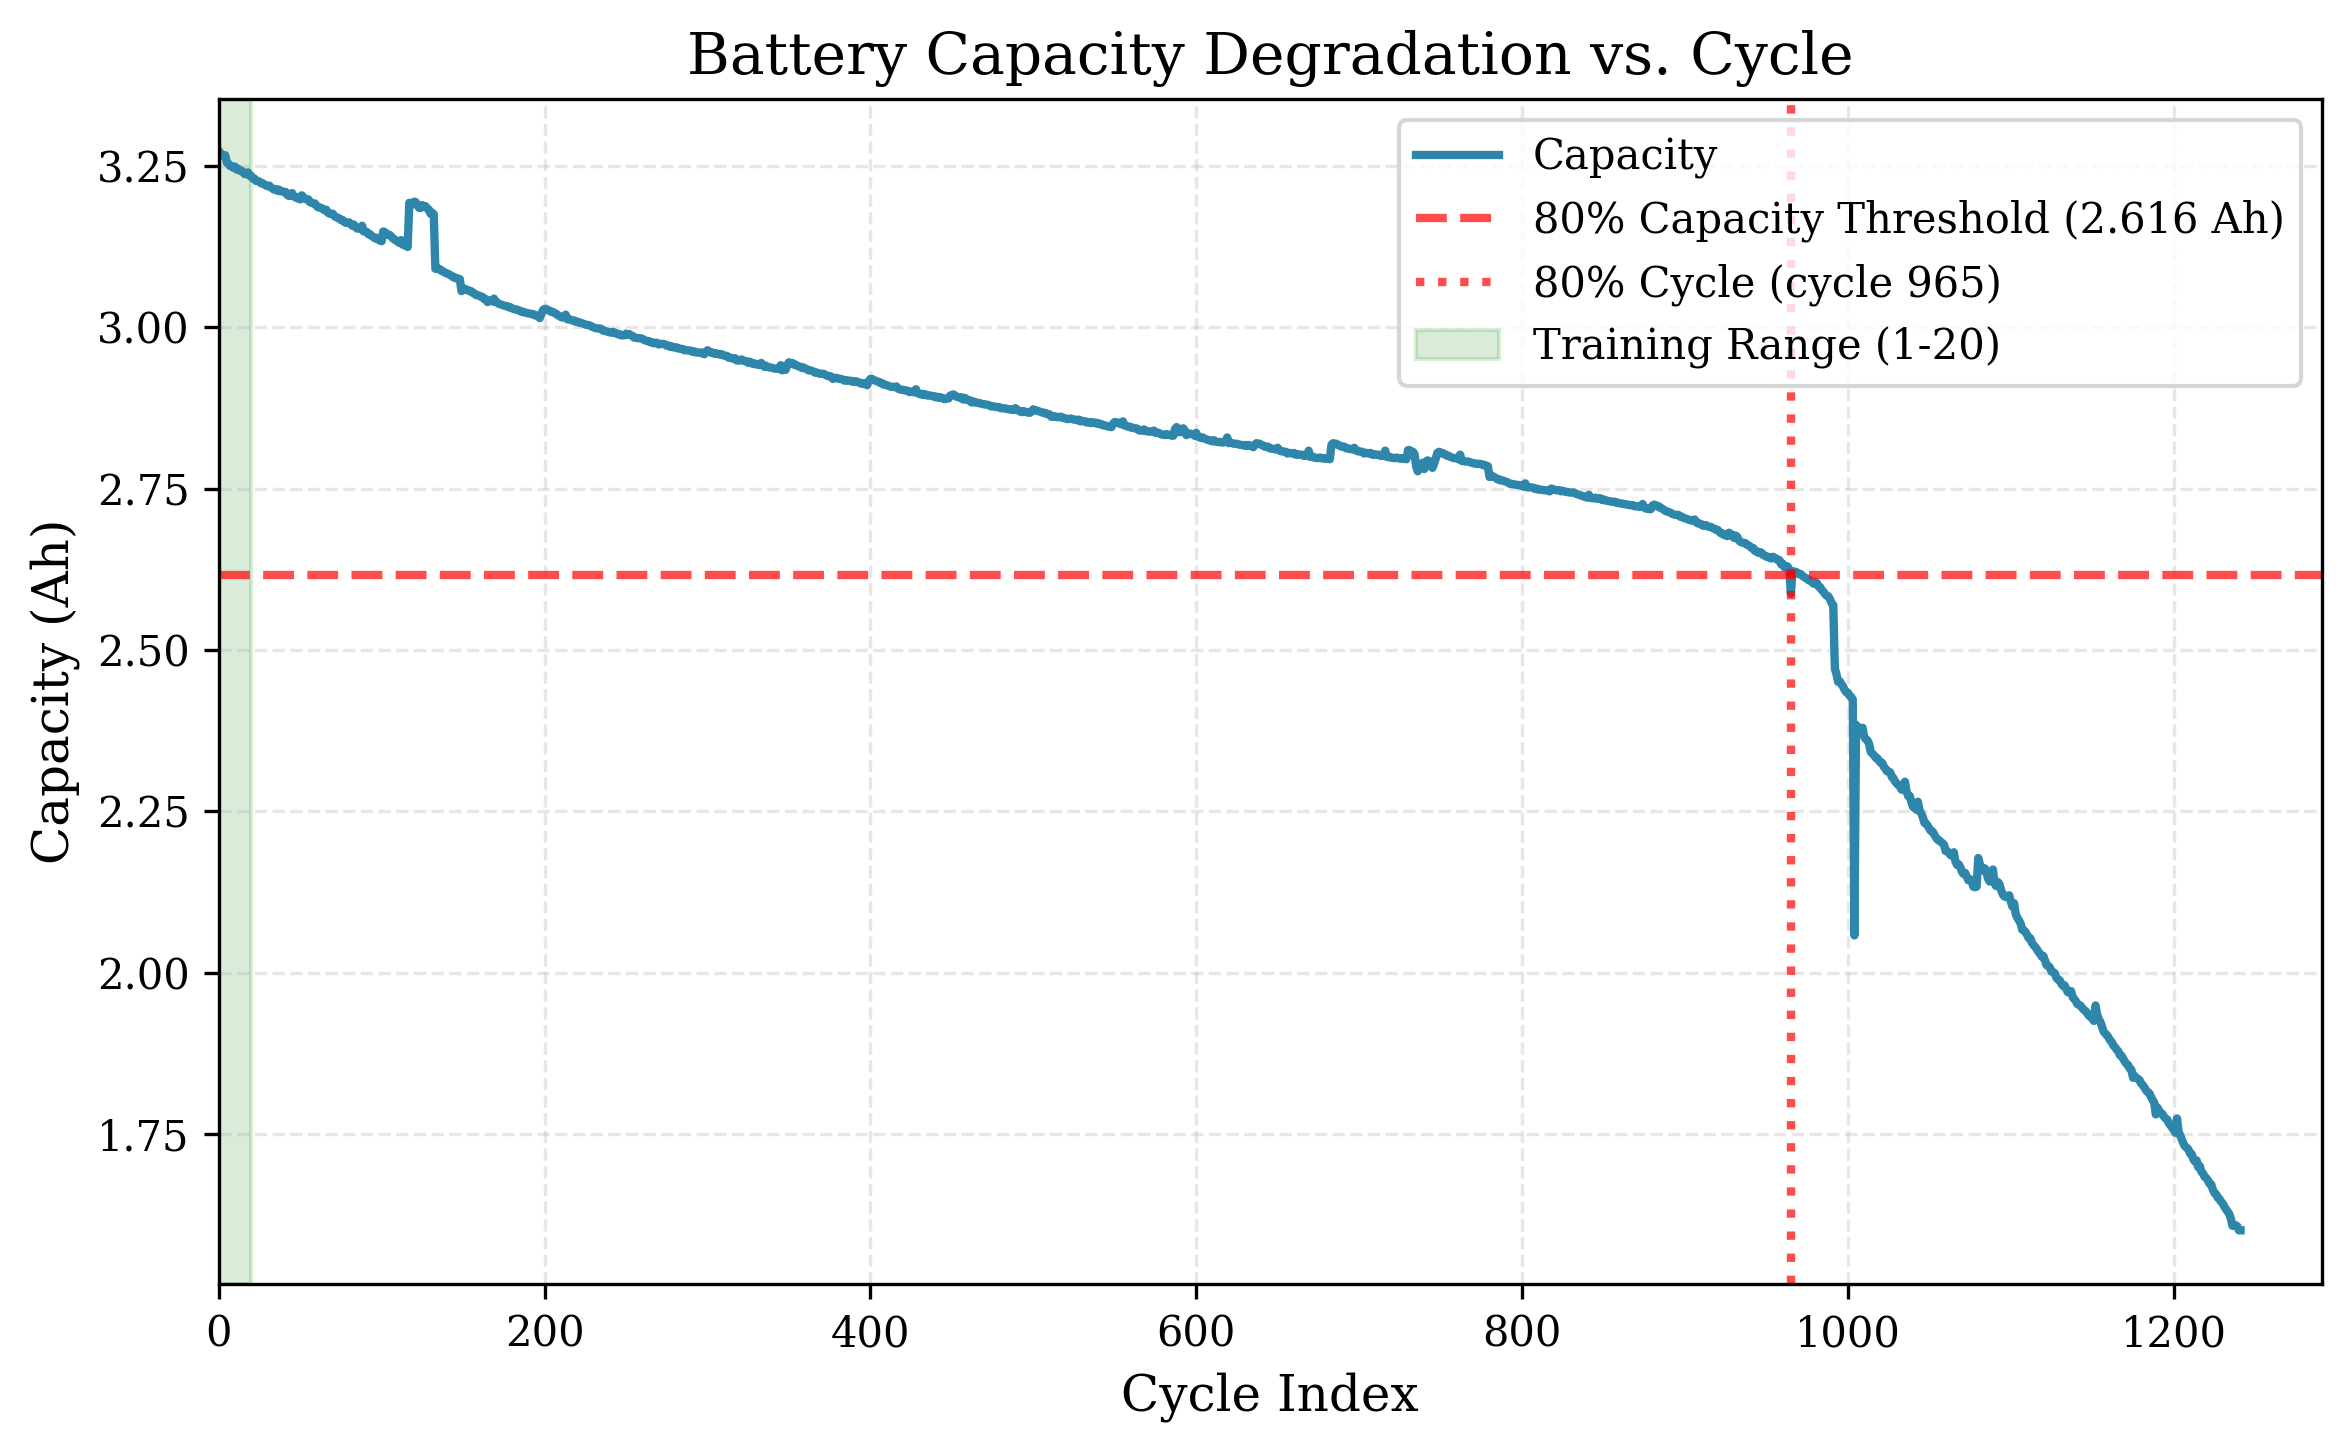

Phase 4.5 Complete
Plot saved: result/phase_4\plot\capacity_vs_cycle.png
  Capacity degradation from 3.270 Ah to 1.601 Ah
  80%-capacity cycle marked at cycle 965


In [6]:
plt.figure(figsize=(8, 5))

plt.plot(features_df['cycle_idx'], features_df['capacity_Ah'], 
         linewidth=2, color='#2E86AB', label='Capacity')

plt.axhline(y=C80, color='red', linestyle='--', linewidth=2, 
            label=f'80% Capacity Threshold ({C80:.3f} Ah)', alpha=0.7)

plt.axvline(x=c80_cycle, color='red', linestyle=':', linewidth=2, 
            label=f'80% Cycle (cycle {c80_cycle})', alpha=0.7)

plt.axvspan(0, 20, alpha=0.15, color='green', label='Training Range (1-20)')

plt.xlabel('Cycle Index')
plt.ylabel('Capacity (Ah)')
plt.title('Battery Capacity Degradation vs. Cycle')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')

plt.xlim(0, len(features_df) + 50)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'capacity_vs_cycle.png'), bbox_inches='tight')
plt.show()

print("Phase 4.5 Complete")
print(f"Plot saved: {os.path.join(PLOT_DIR, 'capacity_vs_cycle.png')}")
print(f"  Capacity degradation from {C_ref:.3f} Ah to {features_df['capacity_Ah'].iloc[-1]:.3f} Ah")
print(f"  80%-capacity cycle marked at cycle {c80_cycle}")

## **4.6 Plot Anomaly Score vs. Cycle (Quantum vs. RBF)**

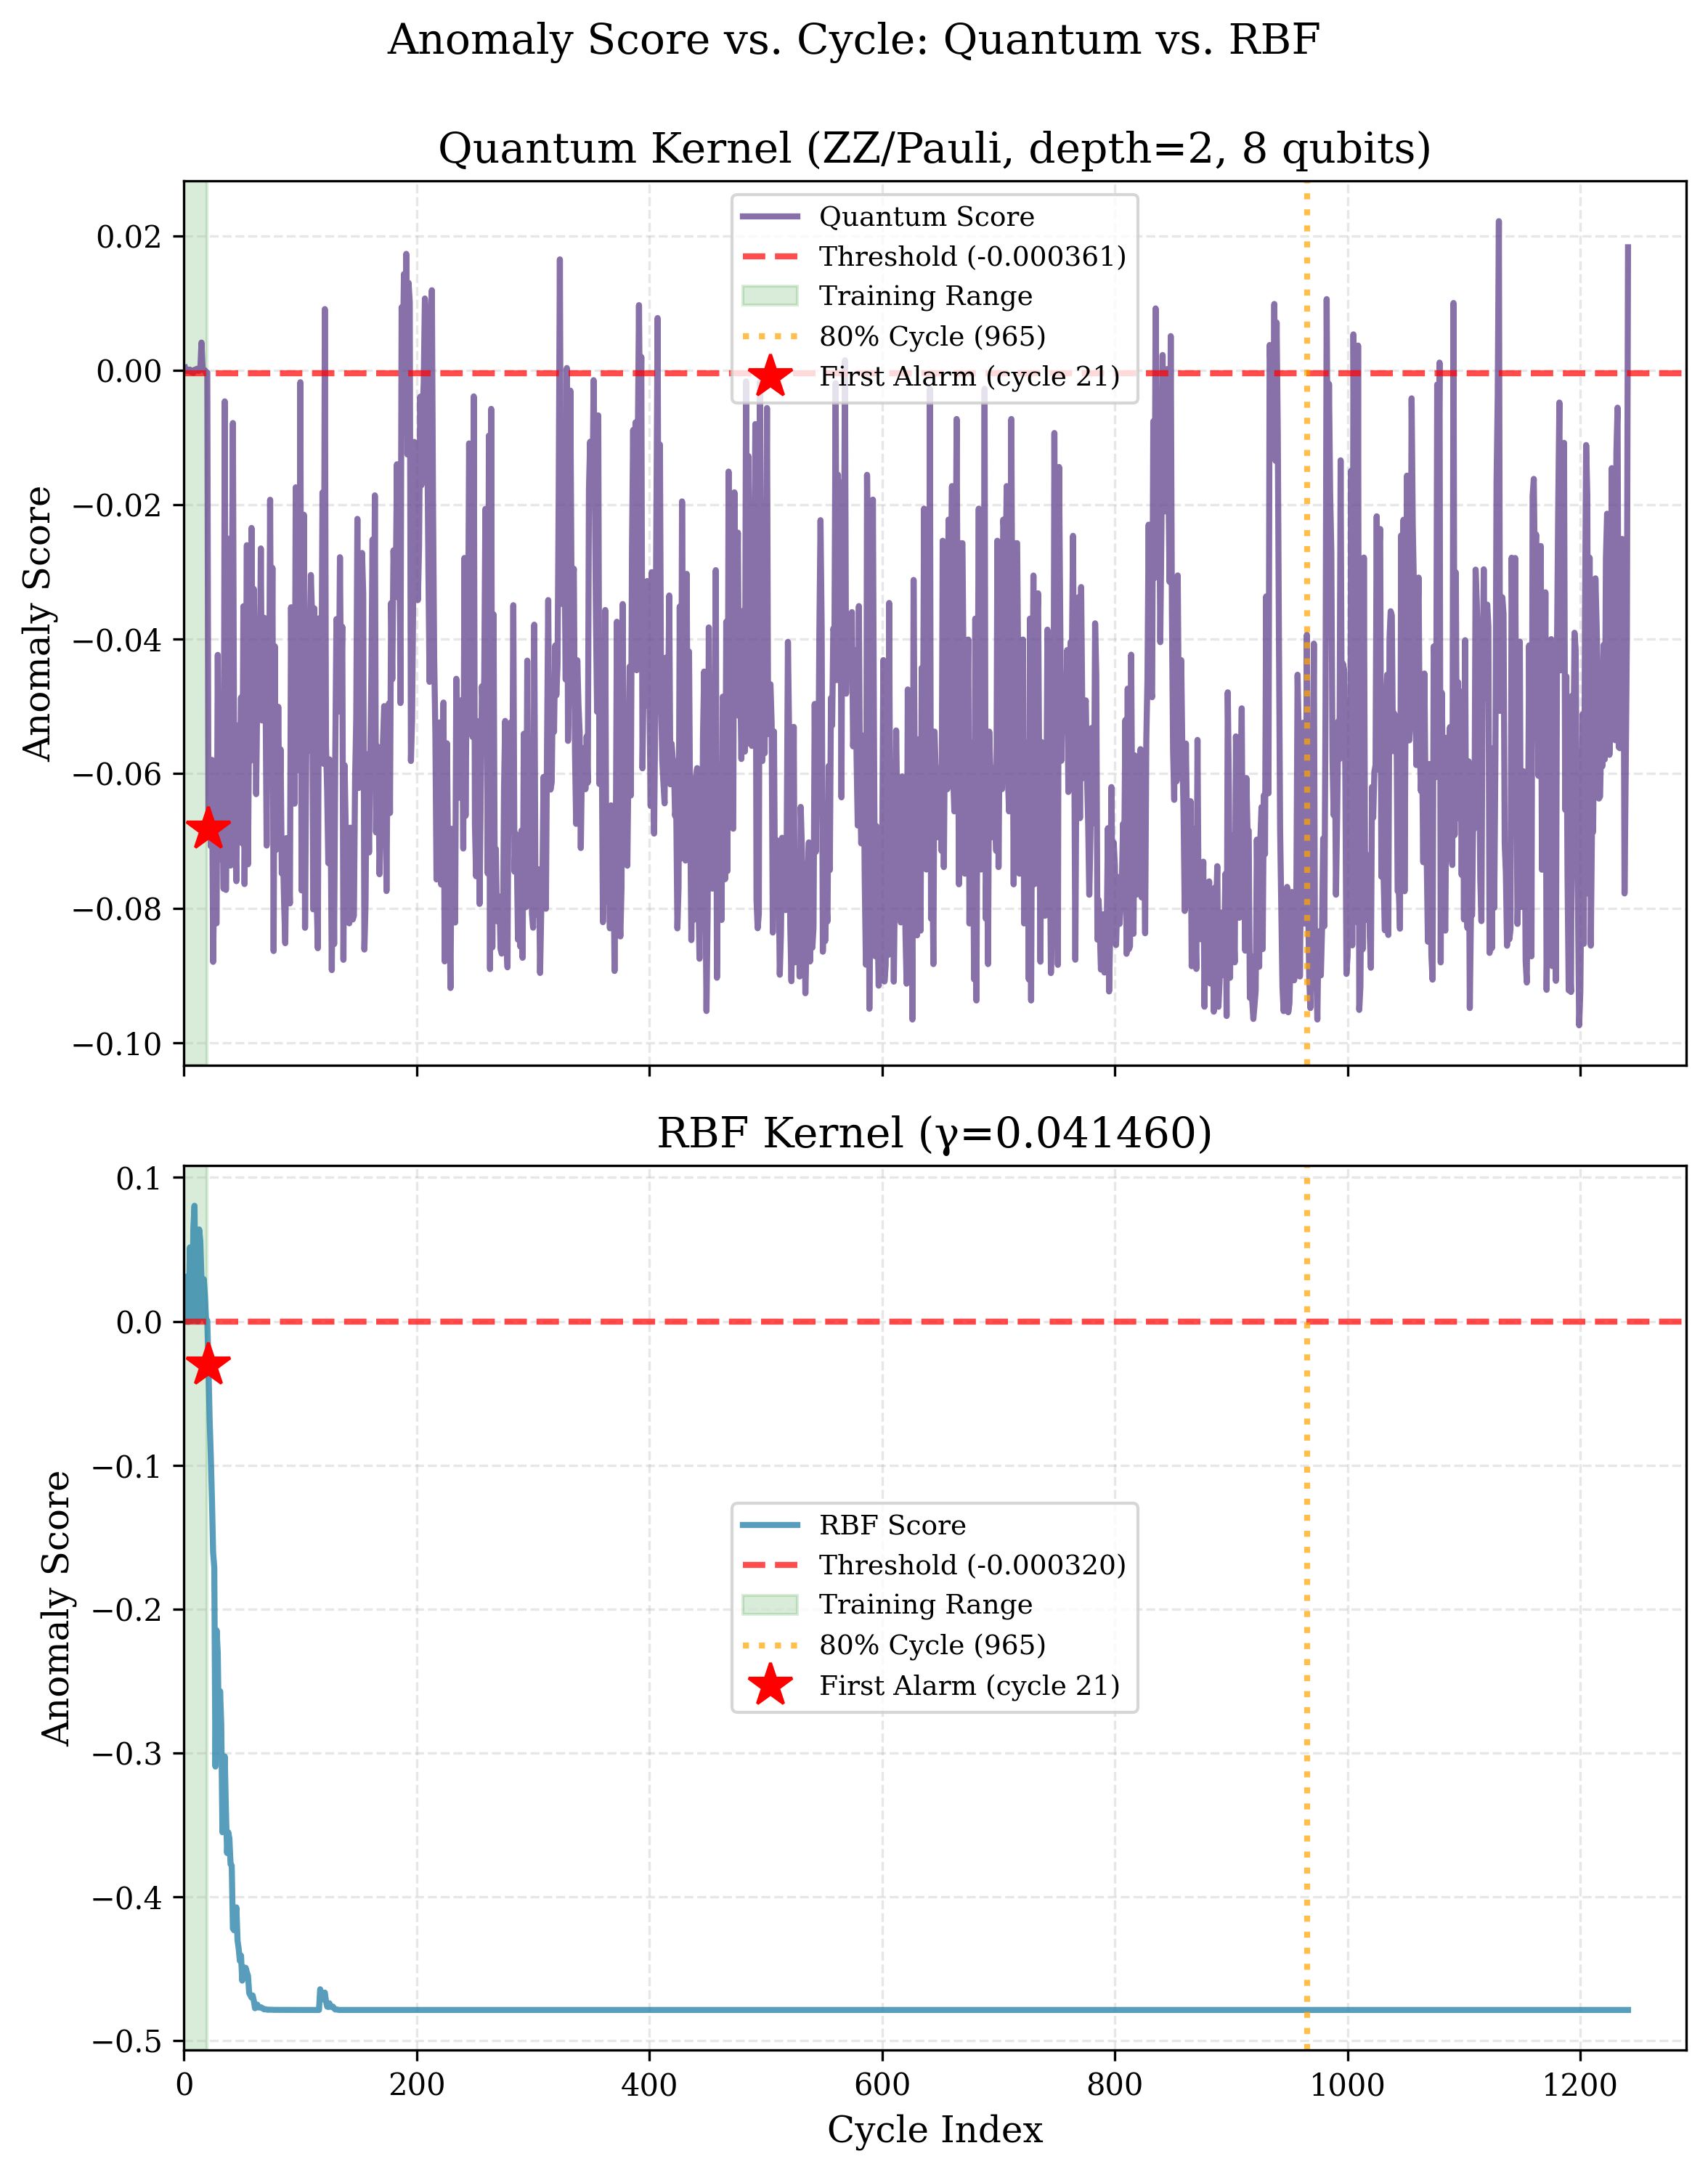

Phase 4.6 Complete
Plot saved: result/phase_4\plot\anomaly_score_vs_cycle_quantum_vs_rbf.png
  Quantum: First alarm at cycle 21, lead-time 944 cycles
  RBF: First alarm at cycle 21, lead-time 944 cycles


In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

ax1.plot(features_df['cycle_idx'], features_df['score_quantum'], 
         linewidth=2, color='#6A4C93', label='Quantum Score', alpha=0.8)

ax1.axhline(y=thresholds['quantum'], color='red', linestyle='--', 
            linewidth=2, label=f'Threshold ({thresholds["quantum"]:.6f})', alpha=0.7)

ax1.axvspan(0, 20, alpha=0.15, color='green', label='Training Range')

ax1.axvline(x=c80_cycle, color='orange', linestyle=':', linewidth=2, 
            label=f'80% Cycle ({c80_cycle})', alpha=0.7)

if first_alarms['quantum']['cycle'] is not None:
    alarm_cycle = first_alarms['quantum']['cycle']
    alarm_score = first_alarms['quantum']['score']
    ax1.plot(alarm_cycle, alarm_score, 'r*', markersize=15, 
             label=f'First Alarm (cycle {alarm_cycle})', zorder=5)

ax1.set_ylabel('Anomaly Score')
ax1.set_title('Quantum Kernel (ZZ/Pauli, depth=2, 8 qubits)')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3, linestyle='--')

ax2.plot(features_df['cycle_idx'], features_df['score_rbf'], 
         linewidth=2, color='#2E86AB', label='RBF Score', alpha=0.8)

ax2.axhline(y=thresholds['rbf'], color='red', linestyle='--', 
            linewidth=2, label=f'Threshold ({thresholds["rbf"]:.6f})', alpha=0.7)

ax2.axvspan(0, 20, alpha=0.15, color='green', label='Training Range')

ax2.axvline(x=c80_cycle, color='orange', linestyle=':', linewidth=2, 
            label=f'80% Cycle ({c80_cycle})', alpha=0.7)

if first_alarms['rbf']['cycle'] is not None:
    alarm_cycle = first_alarms['rbf']['cycle']
    alarm_score = first_alarms['rbf']['score']
    ax2.plot(alarm_cycle, alarm_score, 'r*', markersize=15, 
             label=f'First Alarm (cycle {alarm_cycle})', zorder=5)
else:
    ax2.text(0.5, 0.5, 'No post-training anomaly detected', 
             transform=ax2.transAxes, fontsize=10, color='darkred',
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax2.set_xlabel('Cycle Index')
ax2.set_ylabel('Anomaly Score')
ax2.set_title(f'RBF Kernel (γ={baseline_params["rbf"]["gamma"]:.6f})')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(0, len(features_df) + 50)

plt.suptitle('Anomaly Score vs. Cycle: Quantum vs. RBF', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'anomaly_score_vs_cycle_quantum_vs_rbf.png'), bbox_inches='tight')
plt.show()

print("Phase 4.6 Complete")
print(f"Plot saved: {os.path.join(PLOT_DIR, 'anomaly_score_vs_cycle_quantum_vs_rbf.png')}")
if first_alarms['quantum']['cycle'] is not None:
    print(f"  Quantum: First alarm at cycle {first_alarms['quantum']['cycle']}, lead-time {lead_times['quantum']} cycles")
if first_alarms['rbf']['cycle'] is not None:
    print(f"  RBF: First alarm at cycle {first_alarms['rbf']['cycle']}, lead-time {lead_times['rbf']} cycles")
else:
    print(f"  RBF: No post-training alarm detected")

## **4.7 Plot Kernel Gram Matrix Heatmaps (Quantum & RBF)**

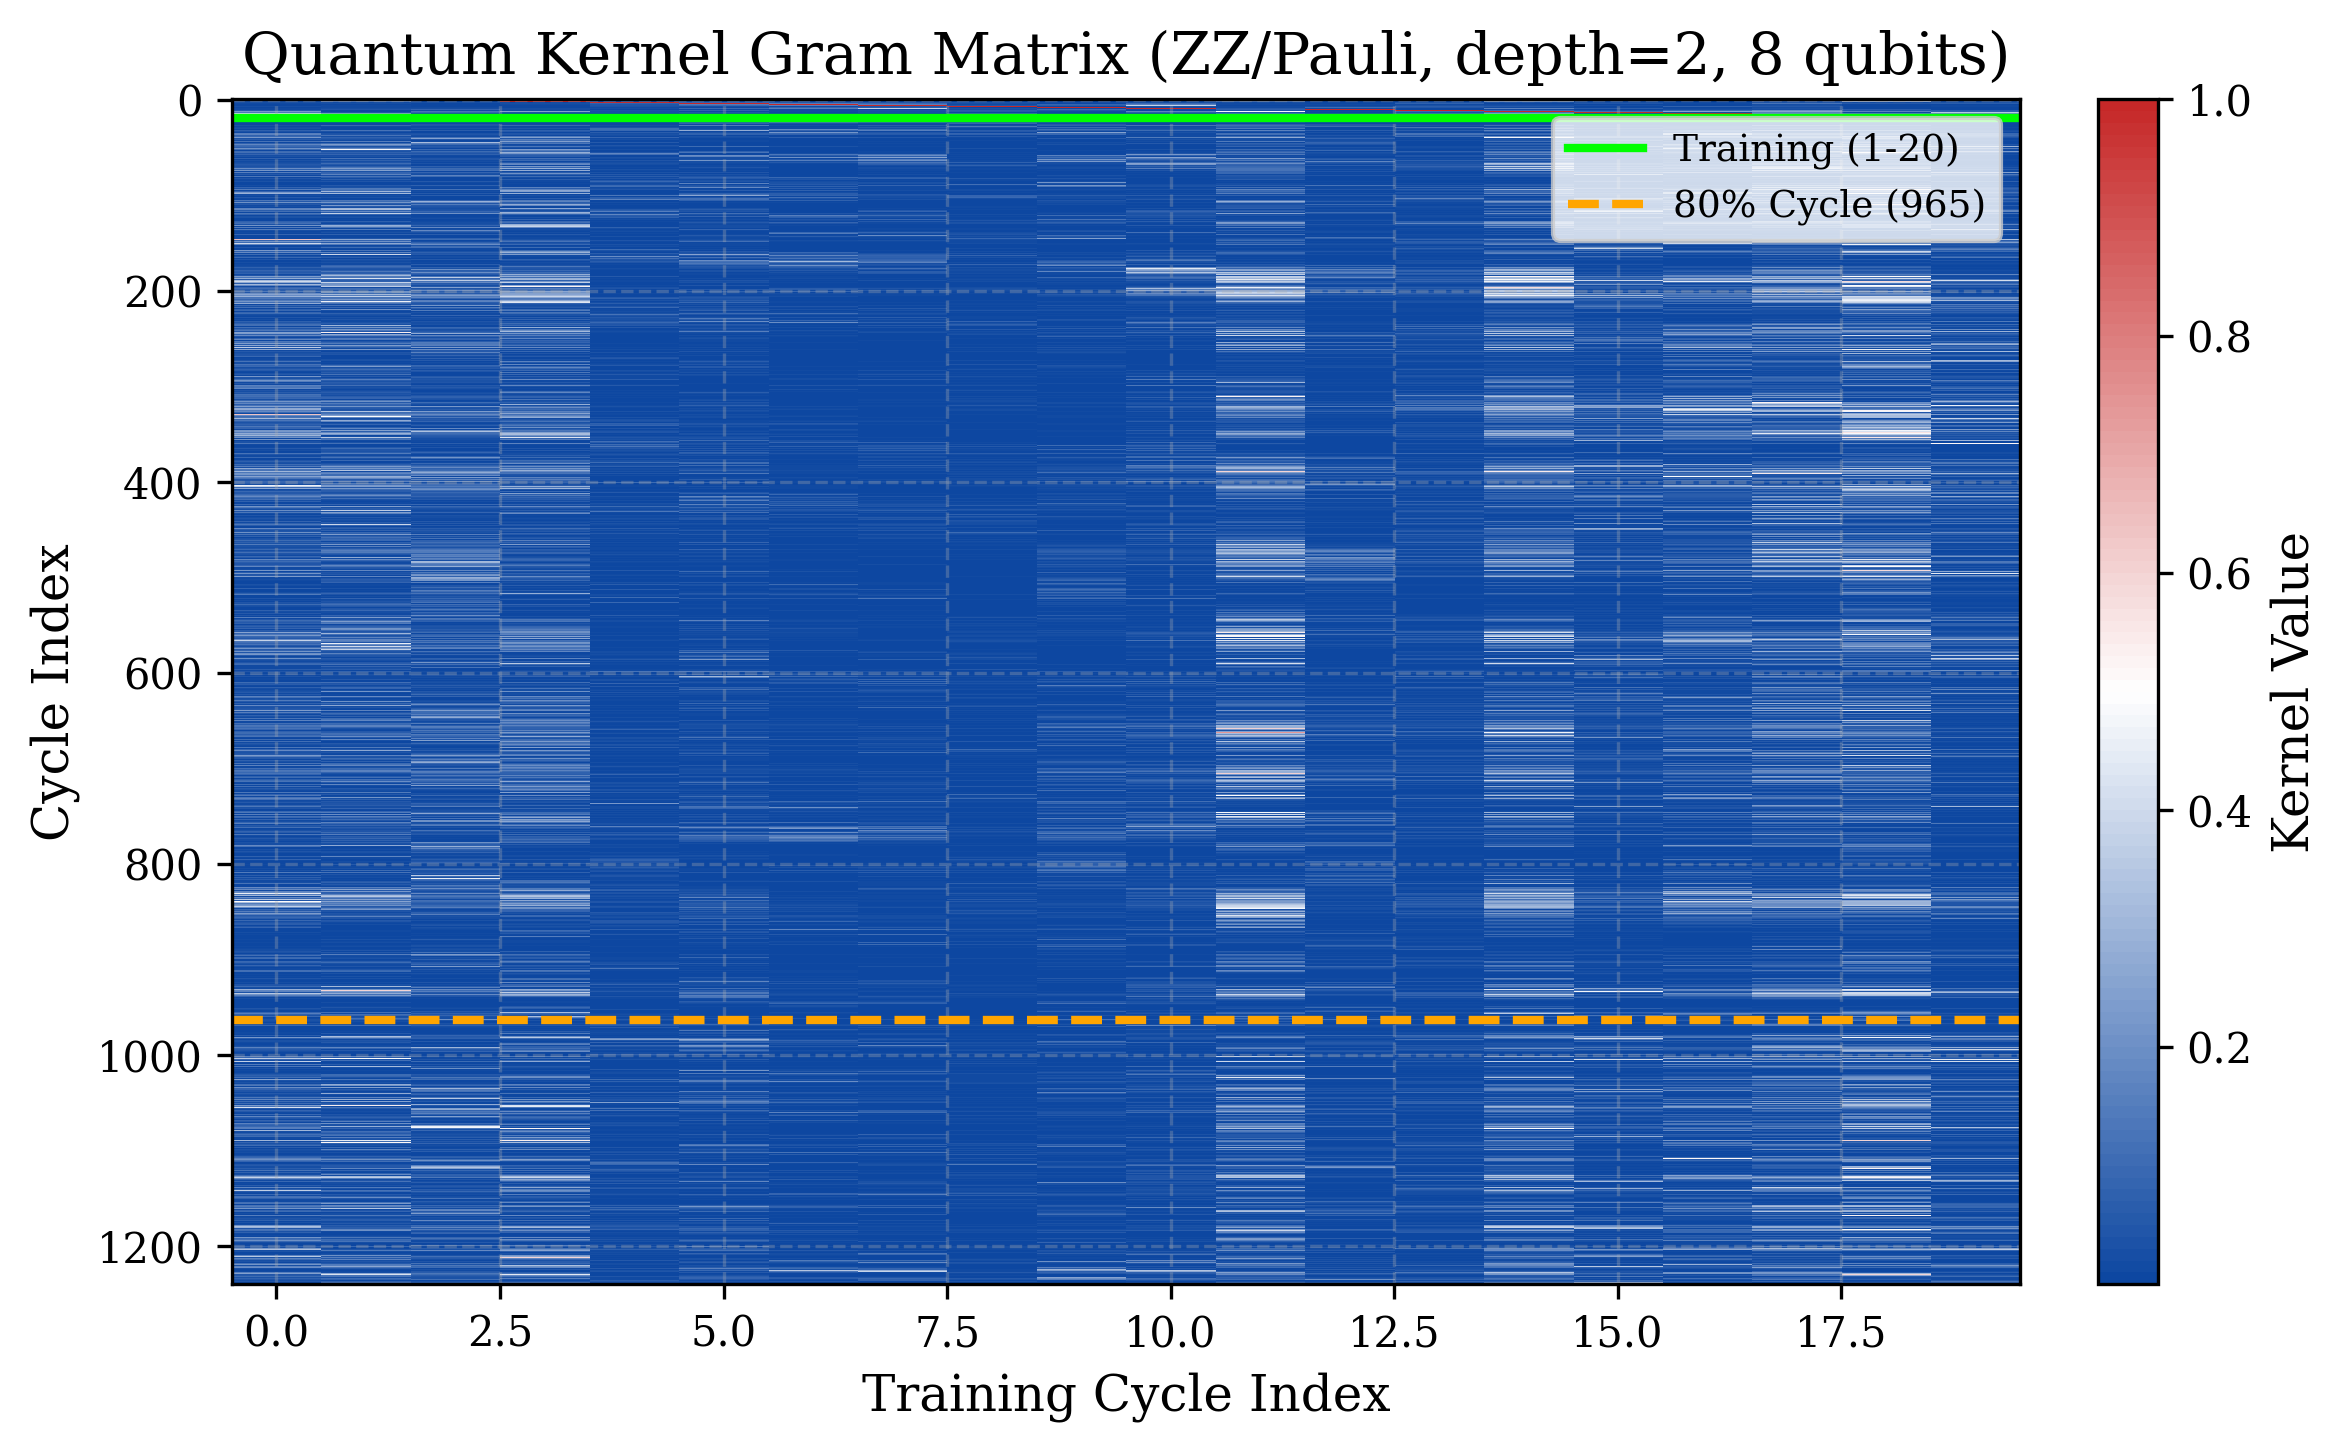

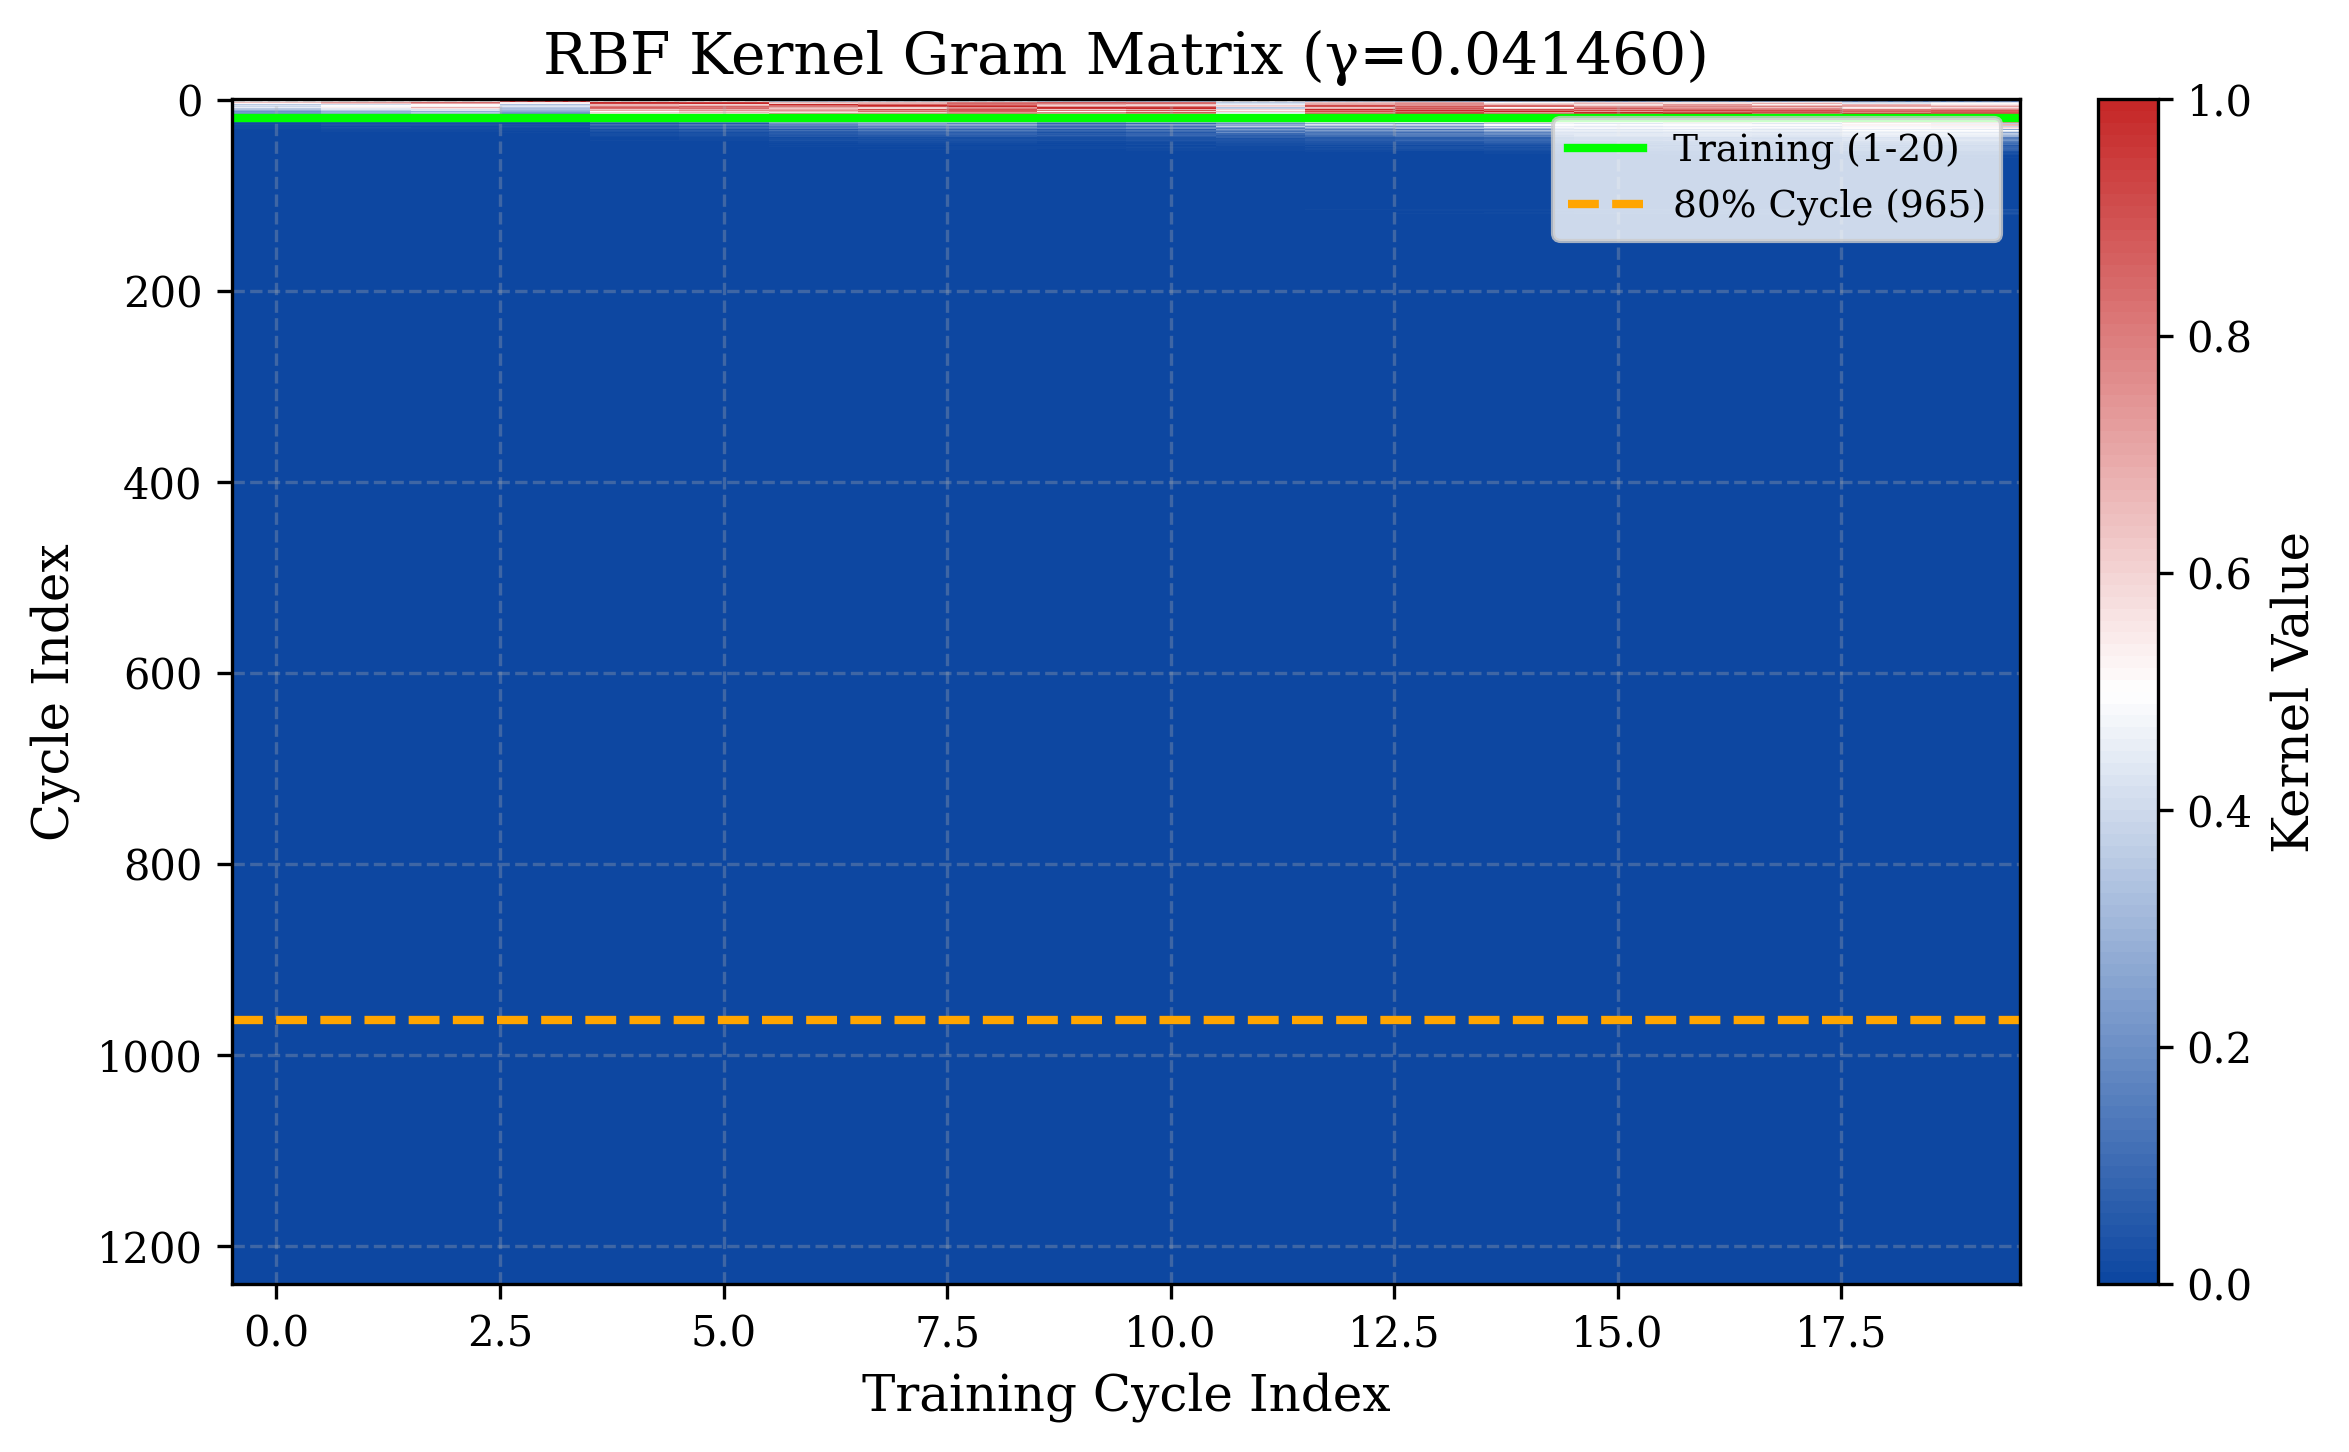

Phase 4.7 Complete
Plots saved:
  result/phase_4\plot\gram_heatmap_quantum.png
  result/phase_4\plot\gram_heatmap_rbf.png

Gram matrix dimensions: (1241, 20)
  Quantum kernel value range: [0.0000, 1.0000]
  RBF kernel value range: [0.0000, 1.0000]


In [8]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['#0D47A1', '#FFFFFF', '#C62828']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(K_quantum_full, cmap=cmap, aspect='auto', interpolation='nearest')
ax.set_xlabel('Training Cycle Index')
ax.set_ylabel('Cycle Index')
ax.set_title('Quantum Kernel Gram Matrix (ZZ/Pauli, depth=2, 8 qubits)')

ax.axhline(y=19.5, color='lime', linestyle='-', linewidth=2, label='Training (1-20)')
ax.axhline(y=c80_cycle-1, color='orange', linestyle='--', linewidth=2, label=f'80% Cycle ({c80_cycle})')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Kernel Value')
ax.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'gram_heatmap_quantum.png'), bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(K_rbf_full, cmap=cmap, aspect='auto', interpolation='nearest')
ax.set_xlabel('Training Cycle Index')
ax.set_ylabel('Cycle Index')
ax.set_title(f'RBF Kernel Gram Matrix (γ={baseline_params["rbf"]["gamma"]:.6f})')

ax.axhline(y=19.5, color='lime', linestyle='-', linewidth=2, label='Training (1-20)')
ax.axhline(y=c80_cycle-1, color='orange', linestyle='--', linewidth=2, label=f'80% Cycle ({c80_cycle})')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Kernel Value')
ax.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'gram_heatmap_rbf.png'), bbox_inches='tight')
plt.show()

print("Phase 4.7 Complete")
print("Plots saved:")
print(f"  {os.path.join(PLOT_DIR, 'gram_heatmap_quantum.png')}")
print(f"  {os.path.join(PLOT_DIR, 'gram_heatmap_rbf.png')}")
print(f"\nGram matrix dimensions: {K_quantum_full.shape}")
print(f"  Quantum kernel value range: [{K_quantum_full.min():.4f}, {K_quantum_full.max():.4f}]")
print(f"  RBF kernel value range: [{K_rbf_full.min():.4f}, {K_rbf_full.max():.4f}]")

## **4.8 Kernel-PCA 2-D Scatter (Quantum & RBF)**

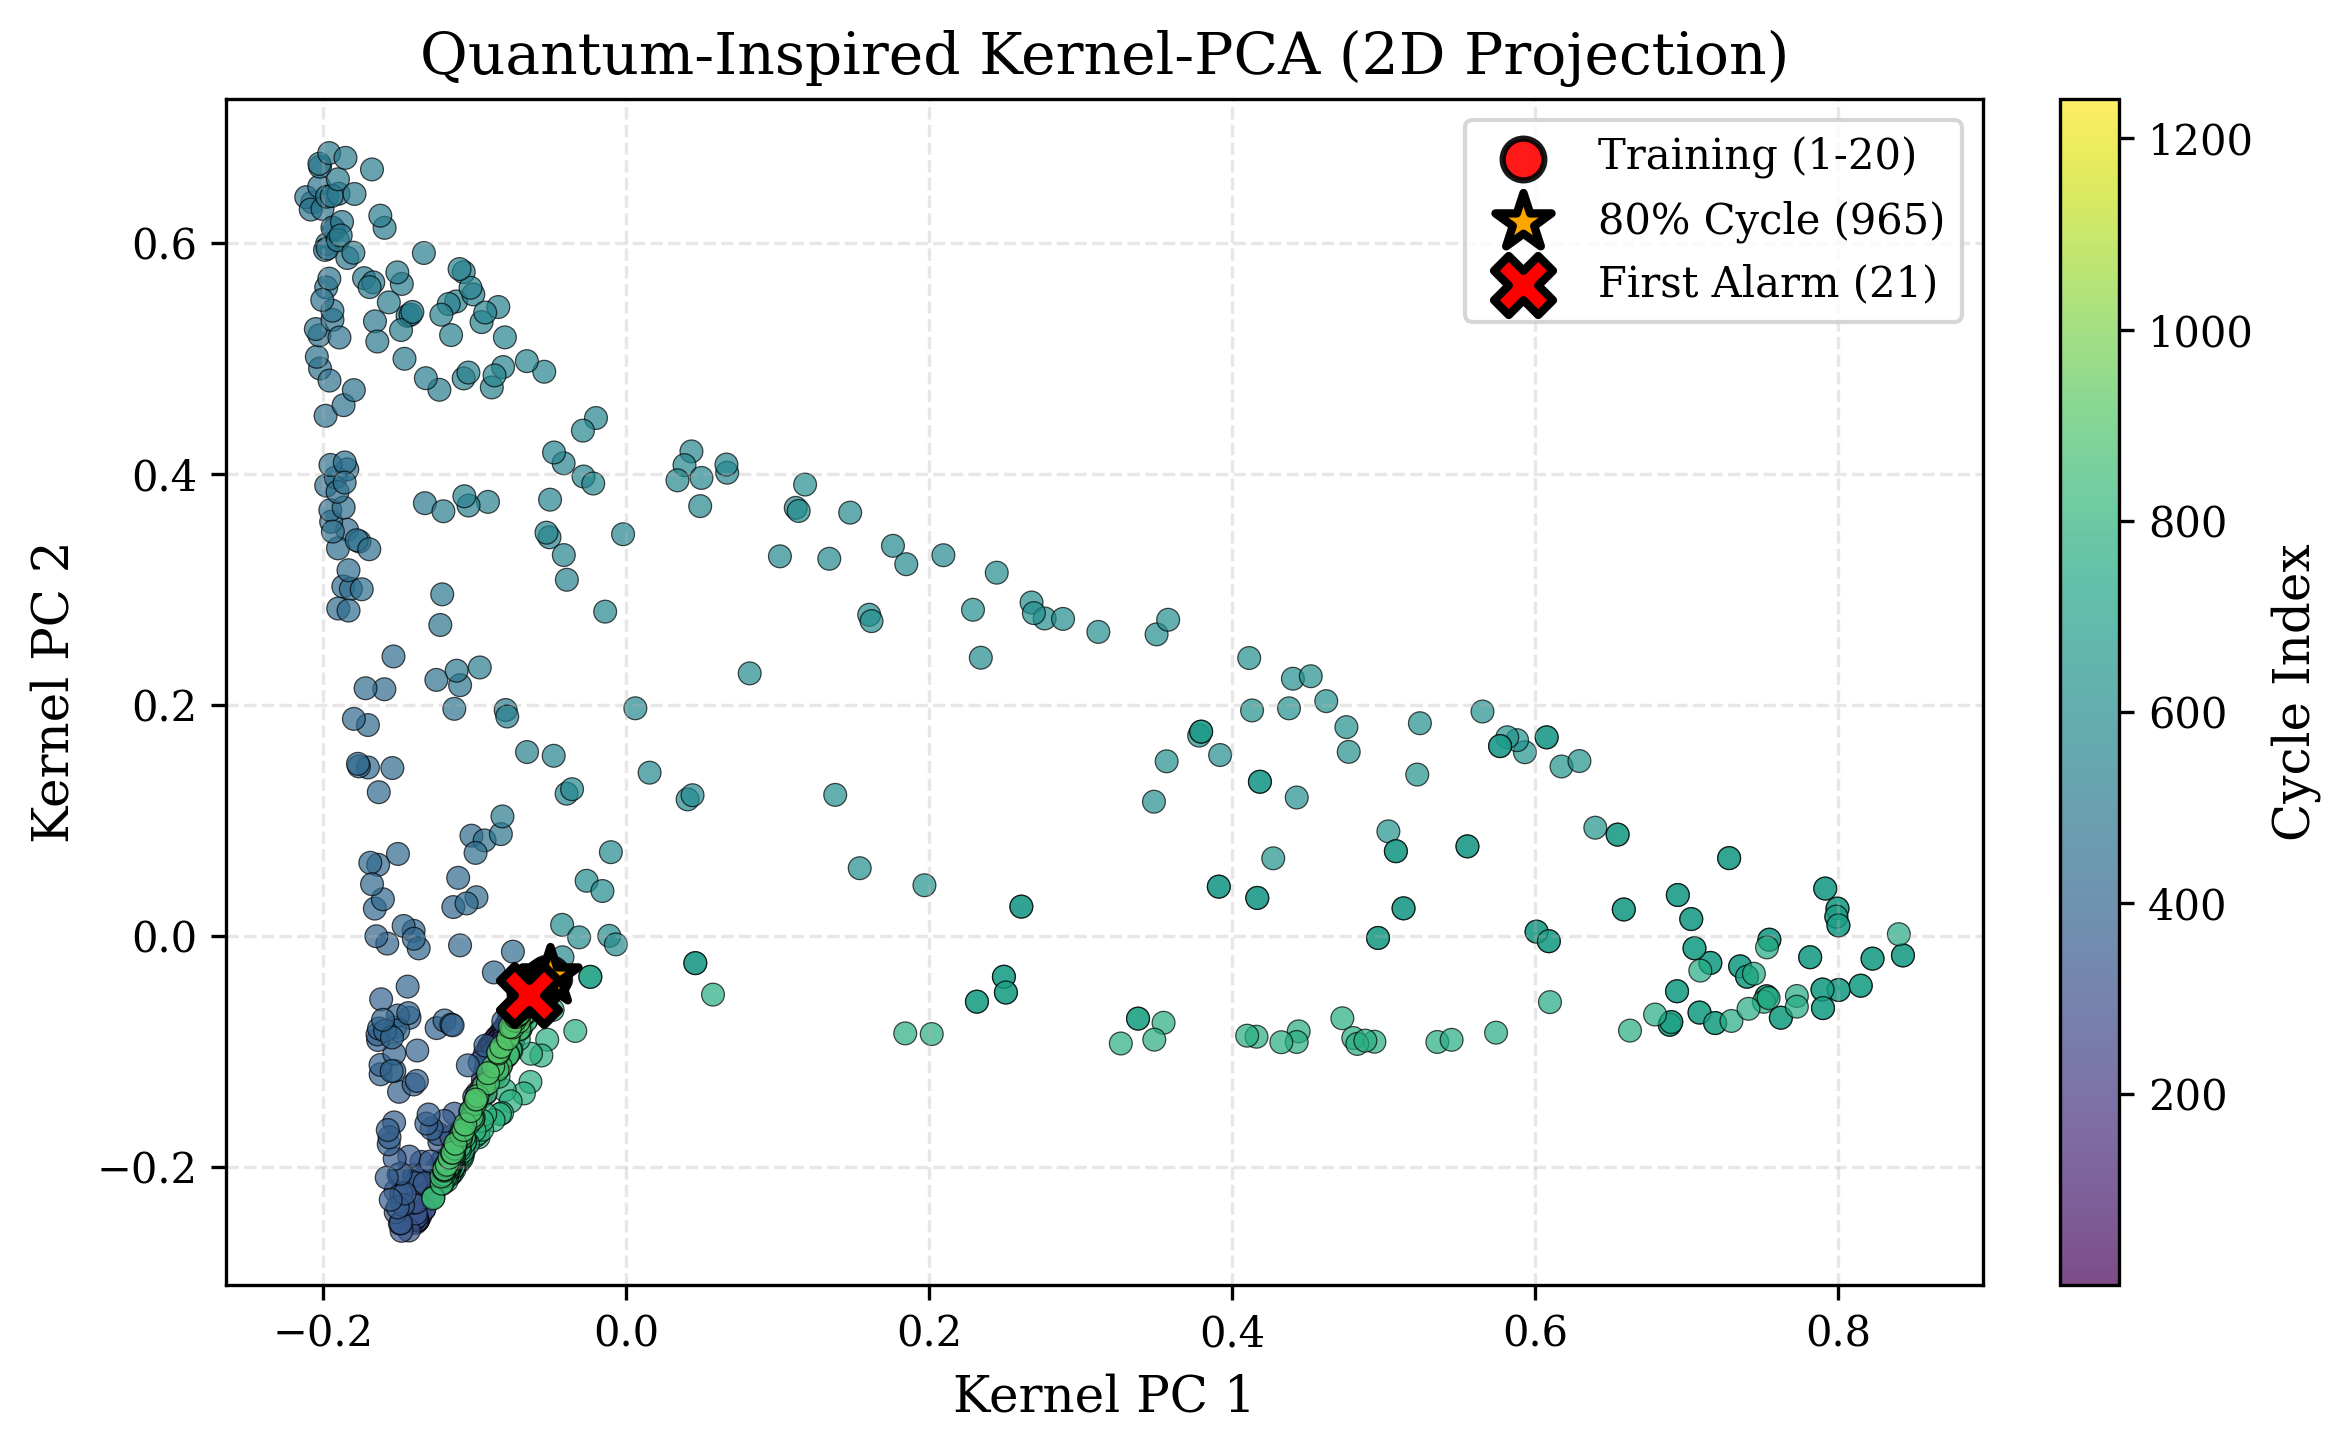

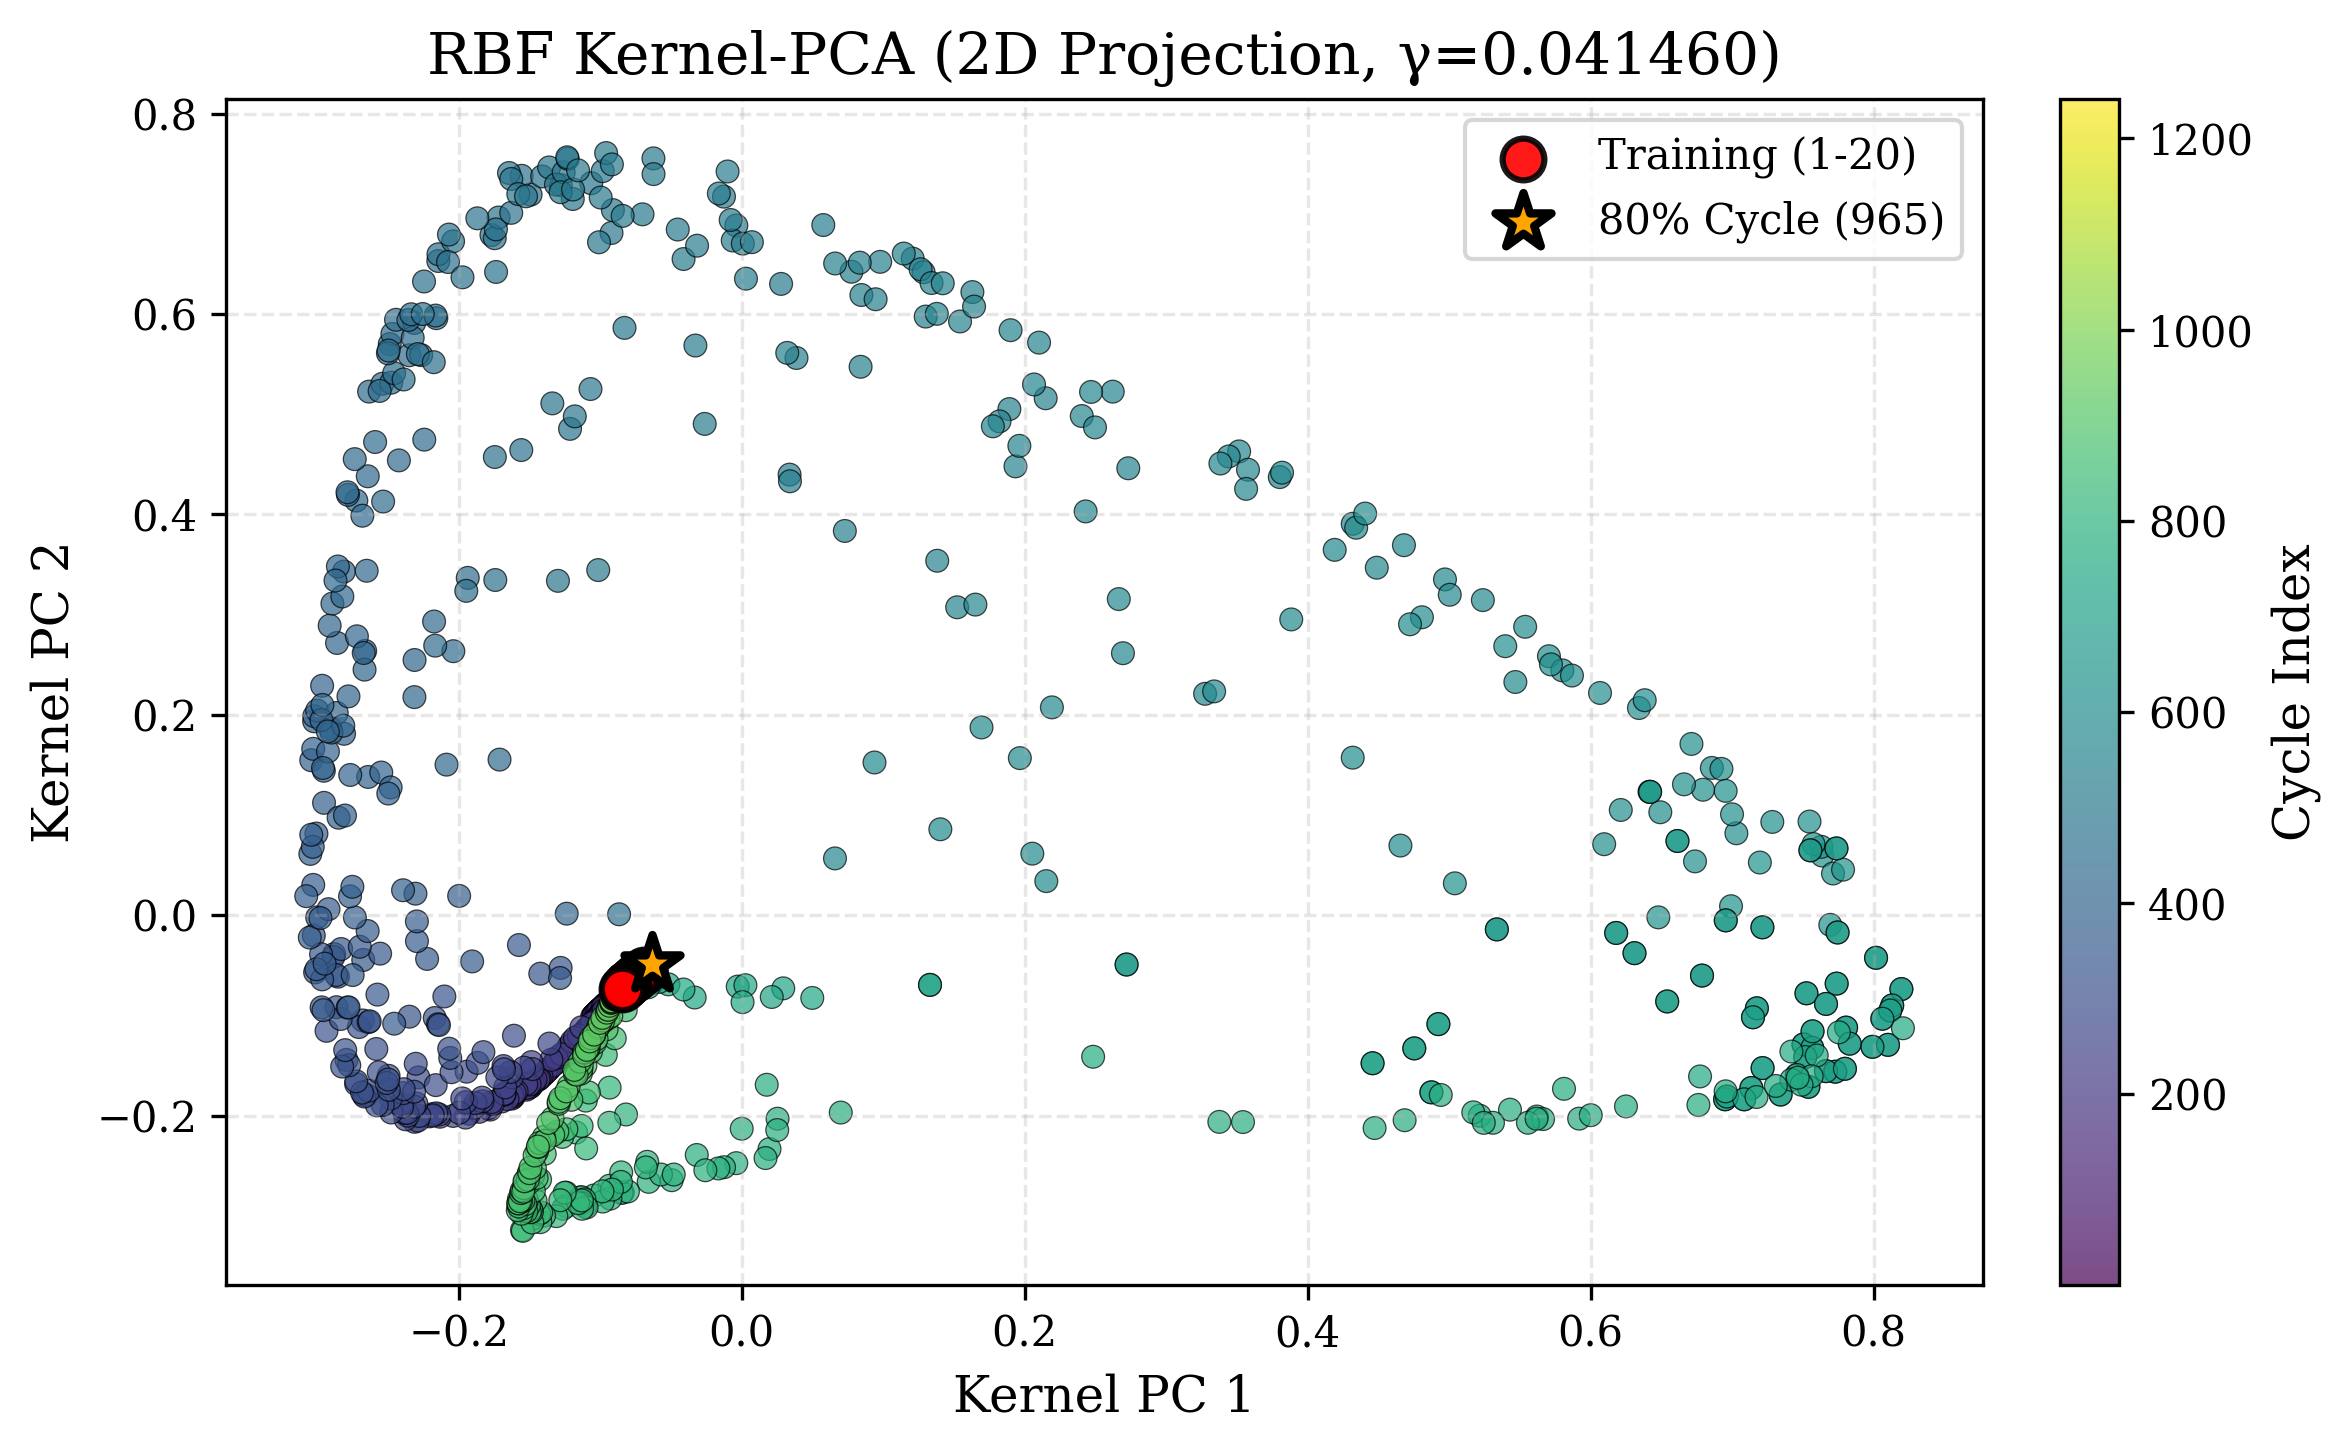

Phase 4.8 Complete
Plots saved:
  result/phase_4\plot\kernel_pca_scatter_quantum.png
  result/phase_4\plot\kernel_pca_scatter_rbf.png

Note: Quantum PCA uses approximation due to non-square kernel matrix


In [10]:
from sklearn.metrics.pairwise import rbf_kernel

feature_cols = ['capacity_Ah', 'energy_Wh', 'duration_s', 'v_min', 'v_max', 'v_mean', 'i_rms', 'dVdt_abs_mean']
X = features_df[feature_cols].values
X_scaled = scaler.transform(X)

K_rbf_square = rbf_kernel(X_scaled, gamma=baseline_params['rbf']['gamma'])

kpca_rbf = KernelPCA(n_components=2, kernel='precomputed', random_state=SEED)
X_kpca_rbf = kpca_rbf.fit_transform(K_rbf_square)

kpca_quantum_approx = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, random_state=SEED)
X_kpca_quantum = kpca_quantum_approx.fit_transform(X_scaled)

cycle_indices = features_df['cycle_idx'].values
train_mask = features_df['cycle_idx'] <= 20
c80_idx = features_df[features_df['cycle_idx'] == c80_cycle].index[0]

fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(X_kpca_quantum[:, 0], X_kpca_quantum[:, 1], 
                     c=cycle_indices, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
ax.scatter(X_kpca_quantum[train_mask, 0], X_kpca_quantum[train_mask, 1], 
           c='red', s=100, marker='o', edgecolors='black', linewidth=1.5, 
           label='Training (1-20)', zorder=5, alpha=0.9)
ax.scatter(X_kpca_quantum[c80_idx, 0], X_kpca_quantum[c80_idx, 1],
           c='orange', s=200, marker='*', edgecolors='black', linewidth=2,
           label=f'80% Cycle ({c80_cycle})', zorder=6)
if first_alarms['quantum']['cycle'] is not None:
    alarm_idx = features_df[features_df['cycle_idx'] == first_alarms['quantum']['cycle']].index[0]
    ax.scatter(X_kpca_quantum[alarm_idx, 0], X_kpca_quantum[alarm_idx, 1],
               c='red', s=200, marker='X', edgecolors='black', linewidth=2,
               label=f'First Alarm ({first_alarms["quantum"]["cycle"]})', zorder=6)
ax.set_xlabel('Kernel PC 1')
ax.set_ylabel('Kernel PC 2')
ax.set_title('Quantum-Inspired Kernel-PCA (2D Projection)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Cycle Index')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'kernel_pca_scatter_quantum.png'), bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(X_kpca_rbf[:, 0], X_kpca_rbf[:, 1], 
                     c=cycle_indices, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.3)
ax.scatter(X_kpca_rbf[train_mask, 0], X_kpca_rbf[train_mask, 1], 
           c='red', s=100, marker='o', edgecolors='black', linewidth=1.5, 
           label='Training (1-20)', zorder=5, alpha=0.9)
ax.scatter(X_kpca_rbf[c80_idx, 0], X_kpca_rbf[c80_idx, 1],
           c='orange', s=200, marker='*', edgecolors='black', linewidth=2,
           label=f'80% Cycle ({c80_cycle})', zorder=6)
ax.set_xlabel('Kernel PC 1')
ax.set_ylabel('Kernel PC 2')
ax.set_title(f'RBF Kernel-PCA (2D Projection, γ={baseline_params["rbf"]["gamma"]:.6f})')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Cycle Index')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'kernel_pca_scatter_rbf.png'), bbox_inches='tight')
plt.show()

print("Phase 4.8 Complete")
print("Plots saved:")
print(f"  {os.path.join(PLOT_DIR, 'kernel_pca_scatter_quantum.png')}")
print(f"  {os.path.join(PLOT_DIR, 'kernel_pca_scatter_rbf.png')}")
print(f"\nNote: Quantum PCA uses approximation due to non-square kernel matrix")

## **4.9 Save Metrics Table (metrics_summary.csv)**

In [11]:
metrics_file = os.path.join(DATA_DIR, 'metrics_summary.csv')
if os.path.exists(metrics_file):
    print("=== Metrics Summary Table ===")
    metrics_final = pd.read_csv(metrics_file)
    print(metrics_final.to_string(index=False))
    print(f"\nFile exists: {metrics_file}")
else:
    print(f"WARNING: Metrics file not found at {metrics_file}")

enhanced_metrics = {
    'Model': [],
    'First_Alarm_Cycle': [],
    'C80_Cycle': [],
    'Lead_Time_Cycles': [],
    'AUROC': [],
    'FPR_Train': [],
    'Threshold': [],
    'N_Support_Vectors': [],
    'Total_Anomalies': [],
    'Post_Training_Anomalies': [],
    'Early_Warning': []
}

model_objects = {
    'quantum': ocsvm_quantum,
    'rbf': ocsvm_rbf,
    'laplacian': ocsvm_laplacian,
    'poly2': ocsvm_poly2,
    'poly3': ocsvm_poly3
}

for model in models:
    enhanced_metrics['Model'].append(model.upper())
    enhanced_metrics['First_Alarm_Cycle'].append(first_alarms[model]['cycle'])
    enhanced_metrics['C80_Cycle'].append(c80_cycle)
    enhanced_metrics['Lead_Time_Cycles'].append(lead_times[model])
    enhanced_metrics['AUROC'].append(f"{auroc_scores[model]:.4f}")
    enhanced_metrics['FPR_Train'].append(0.05)
    enhanced_metrics['Threshold'].append(f"{thresholds[model]:.6f}")
    enhanced_metrics['N_Support_Vectors'].append(model_objects[model].n_support_[0])
    
    total_anom = features_df[f'anomaly_{model}'].sum()
    post_train_anom = features_df[
        (features_df['cycle_idx'] > 20) & 
        (features_df[f'anomaly_{model}'] == True)
    ].shape[0]
    
    enhanced_metrics['Total_Anomalies'].append(total_anom)
    enhanced_metrics['Post_Training_Anomalies'].append(post_train_anom)
    enhanced_metrics['Early_Warning'].append('Yes' if lead_times[model] is not None and lead_times[model] > 0 else 'No' if lead_times[model] is not None else 'N/A')

enhanced_df = pd.DataFrame(enhanced_metrics)

print("\n=== Enhanced Metrics Summary ===")
print(enhanced_df.to_string(index=False))

enhanced_df.to_csv(os.path.join(DATA_DIR, 'metrics_summary_enhanced.csv'), index=False)

print("\n=== Files Saved ===")
print(f"  {os.path.join(DATA_DIR, 'metrics_summary.csv')}")
print(f"  {os.path.join(DATA_DIR, 'metrics_summary_enhanced.csv')}")

print("\n=== Key Findings ===")
print(f"• Reference capacity (C_ref): {C_ref:.4f} Ah")
print(f"• 80% capacity threshold (C80): {C80:.4f} Ah")
print(f"• 80%-capacity cycle: {c80_cycle}")
print(f"• Training range: cycles 1-20")
print(f"• Total cycles analyzed: {len(features_df)}")

if lead_times['quantum'] is not None:
    print(f"\n• Quantum lead-time: {lead_times['quantum']} cycles")
    print(f"• Quantum first alarm: cycle {first_alarms['quantum']['cycle']}")
    
best_auroc_model = max(auroc_scores, key=auroc_scores.get)
print(f"• Best AUROC: {best_auroc_model.upper()} ({auroc_scores[best_auroc_model]:.4f})")

print("\nPhase 4.9 Complete")

=== Metrics Summary Table ===
    model  first_alarm_cycle  c80_cycle  lead_time    auroc  fpr_train     threshold  n_support_vectors early_warning
  quantum                 21        965        944 0.495401       0.05 -3.605755e-04                 19           Yes
      rbf                 21        965        944 0.575648       0.05 -3.202940e-04                  7           Yes
laplacian                 21        965        944 0.999812       0.05 -2.276020e-04                  9           Yes
    poly2                 24        965        941 0.000541       0.05  1.760729e-07                  2           Yes
    poly3                 24        965        941 0.996061       0.05  5.727211e-07                  2           Yes

File exists: result/phase_4\data\metrics_summary.csv

=== Enhanced Metrics Summary ===
    Model  First_Alarm_Cycle  C80_Cycle  Lead_Time_Cycles  AUROC  FPR_Train Threshold  N_Support_Vectors  Total_Anomalies  Post_Training_Anomalies Early_Warning
  QUANTUM    